In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from ml_features.features import prepare_features
from ml_features.customer_features import create_customer_features
from ml_features.sequence_features import create_sequence_features
from ml_training.train_rf import train_rf
from ml_evaluation.dashboard import model_evaluation_report

import warnings
warnings.filterwarnings('ignore')


In [2]:
from wandbhelper.util import init_wandb, log_all_plots, log_plot_as_image

wandb_run_id = init_wandb(run_name="features_engineering")
print(f"Run ID {wandb_run_id}")

wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /home/valeriya/.netrc.
wandb: Currently logged in as: vslovik (homeserve) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Run ID 4edmzs08


In [3]:
# Load data
df_quotes = pd.read_csv('cleaned_quote_data.csv')
df_quotes['dt_creation_devis'] = pd.to_datetime(df_quotes['dt_creation_devis'])

print(f"\n📊 Original quote data: {len(df_quotes):,} quotes")


📊 Original quote data: 38,333 quotes


In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

from etl.util import prepare_dataset_without_leakage
from ml_features.features import prepare_features
from ml_features.customer_features import create_customer_features
from ml_features.sequence_features  import create_sequence_features
from ml_training.train_rf import train_rf
from ml_evaluation.dashboard import model_evaluation_report

import warnings
warnings.filterwarnings('ignore')

# Load original clean quote data
df_quotes = pd.read_csv('cleaned_quote_data.csv')
df_quotes['dt_creation_devis'] = pd.to_datetime(df_quotes['dt_creation_devis'])

print(f"\n📊 Original quote data: {len(df_quotes):,} quotes from {df_quotes['numero_compte'].nunique():,} customers")


print("\n" + "="*80)
print("STRATEGY: CREATE MEANINGFUL SEQUENCE FEATURES")
print("="*80)

# 1. Enhanced customer features
customer_df = create_customer_features(df_quotes)
len(customer_df)

# 2. Sequence features (for multi-quote customers)
sequence_df = create_sequence_features(df_quotes)
print(sequence_df.columns)

sequence_df = pd.merge(
    sequence_df, 
    customer_df, 
    on='numero_compte', 
    how='left',
    suffixes=('_seq', '')  # Explicit suffixes
)

print("Columns:", sequence_df.columns.tolist())

# Now it's clear which column is which
y_sequence = sequence_df['converted']  # From sequence features
y_customer = sequence_df['converted']  # From customer features

# For modeling, use the sequence version
X_customer = customer_df.drop(columns=['numero_compte', 'converted'], errors='ignore')
X_customer_clean, y_customer_clean = prepare_features(X_customer, y_customer, "Customer Features")

columns_to_drop =  [x for x in sequence_df.columns if '_seq' in x]
columns_to_drop.extend(['numero_compte', 'converted'])
X_sequence = sequence_df.drop(columns=columns_to_drop, errors='ignore')

X_sequence_clean, y_sequence_clean = prepare_features(X_sequence, y_sequence, "Sequence Features")


📊 Original quote data: 38,333 quotes from 25,930 customers

STRATEGY: CREATE MEANINGFUL SEQUENCE FEATURES
Creating enhanced customer features...
  Total customers: 25,930
✓ Created features for 25,930 customers
✓ New features: ['numero_compte', 'total_quotes', 'converted', 'avg_days_between_quotes', 'std_days_between_quotes', 'max_days_between_quotes', 'engagement_density', 'price_trajectory', 'unique_product_families', 'product_consistency']...
Creating sequence features (this may take a moment)...
  Total customers: 25,930
✓ Created features for 25,930 customers
✓ New features: ['numero_compte', 'total_quotes', 'converted', 'avg_days_since_first_quote', 'std_days_since_first_quote', 'max_days_since_first_quote', 'avg_recent_quote_count', 'std_recent_quote_count', 'avg_recent_avg_price', 'std_recent_avg_price']...
Index(['numero_compte', 'total_quotes', 'converted',
       'avg_days_since_first_quote', 'std_days_since_first_quote',
       'max_days_since_first_quote', 'avg_recent_quo

In [5]:
print("\n" + "="*80)
print("MODEL TRAINING WITH PROPER VISUALIZATIONS")
print("="*80)

# Test 1: Customer features
print("\n🧪 CUSTOMER FEATURES MODEL")
result_customer = train_rf(X_customer_clean, y_customer_clean, 'customer_model')

# Create predictions for visualizations
X_train, X_test, y_train, y_test = train_test_split(
    X_customer_clean, y_customer_clean, test_size=0.2, random_state=42
)
y_pred = result_customer['model'].predict(X_test)


MODEL TRAINING WITH PROPER VISUALIZATIONS

🧪 CUSTOMER FEATURES MODEL
✓ Model saved: customer_model.pkl
✓ AUC: 0.675


In [6]:
y_pred_proba = result_customer['model'].predict_proba(X_test)[:, 1]

In [7]:
# plots = log_all_plots(y_test, y_pred_proba, wandb_run_id, "Base Customer Model")
# for k, plot in plots.items():
#     plot.show()

In [8]:
# Test 2: Sequence features
print("\n🧪 SEQUENCE FEATURES MODEL")
result_sequence = train_rf(X_sequence_clean, y_sequence_clean, 'sequence_model')

# Create predictions for sequence model
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_sequence_clean, y_sequence_clean, test_size=0.2, random_state=42
)
y_pred_seq = result_sequence['model'].predict(X_test_seq)
y_pred_proba_seq = result_sequence['model'].predict_proba(X_test_seq)[:, 1]



🧪 SEQUENCE FEATURES MODEL
✓ Model saved: sequence_model.pkl
✓ AUC: 0.734


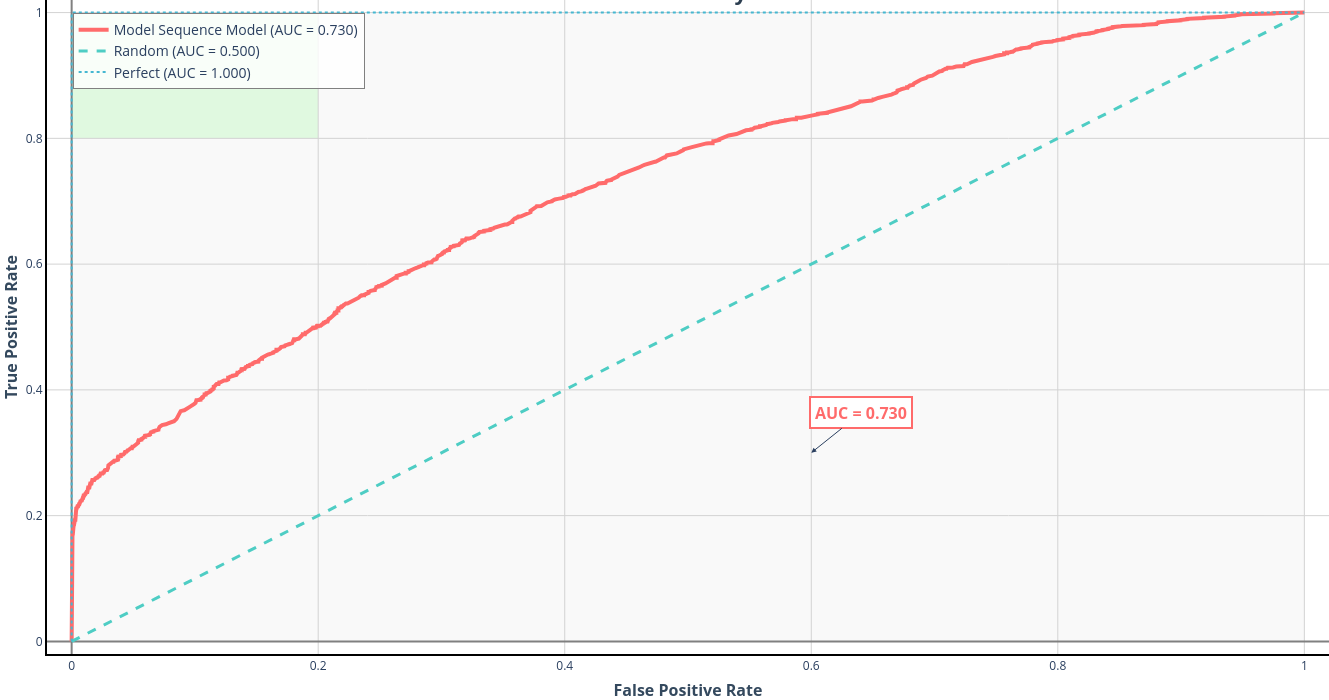

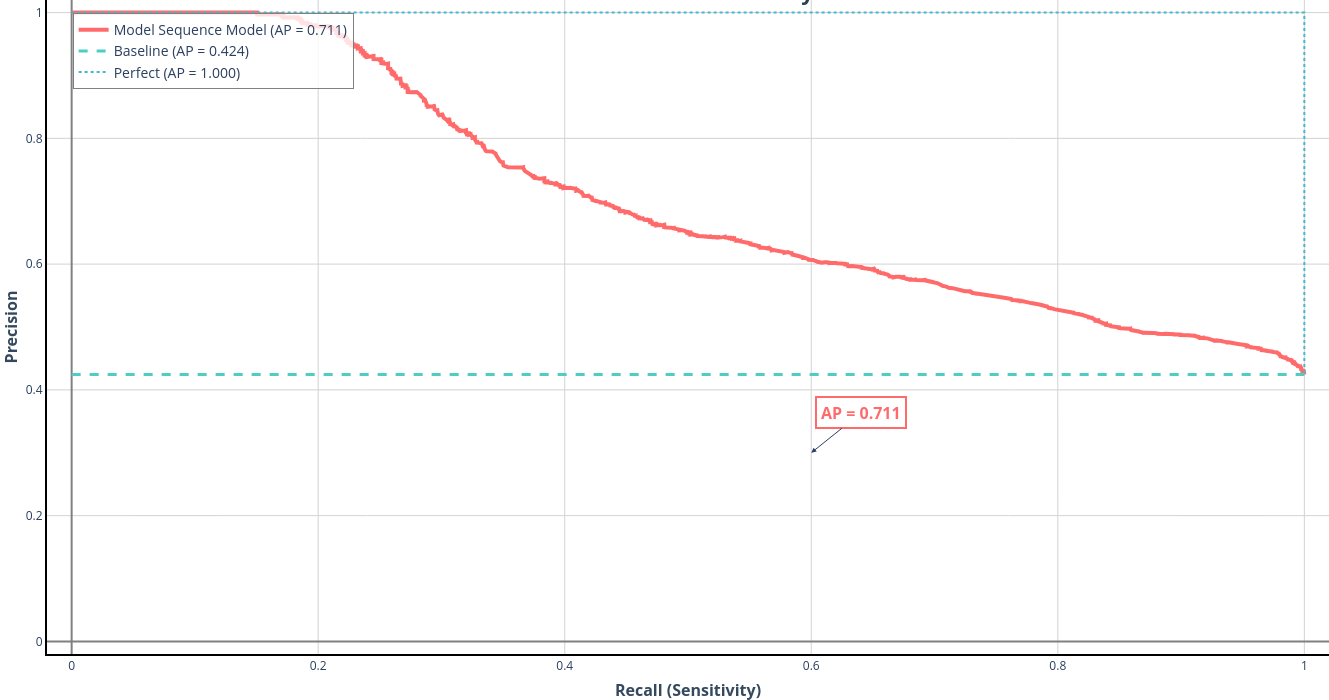

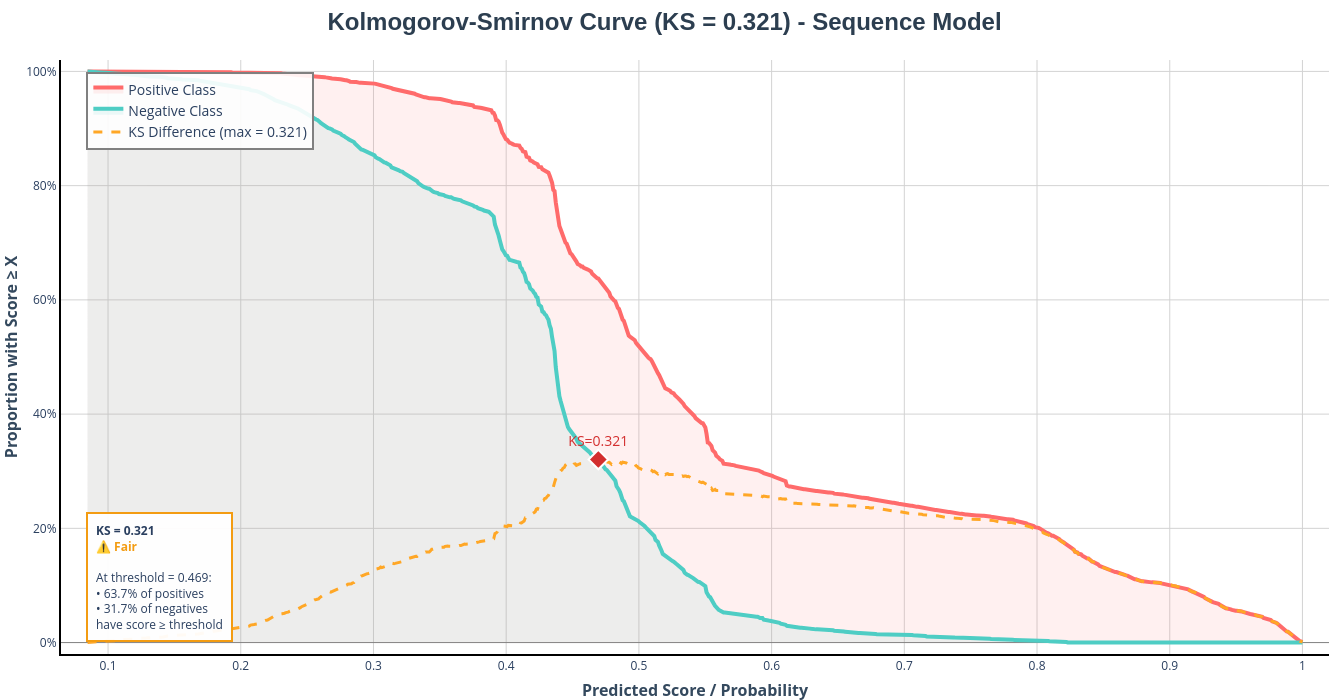

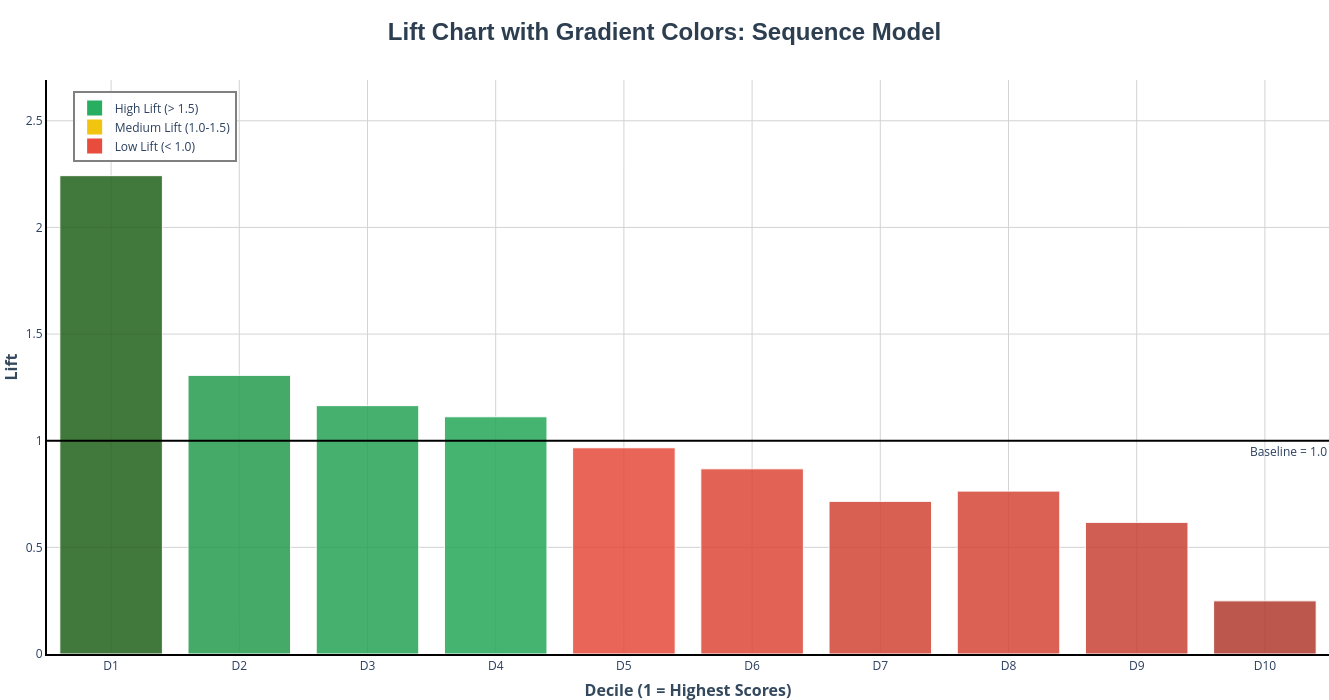

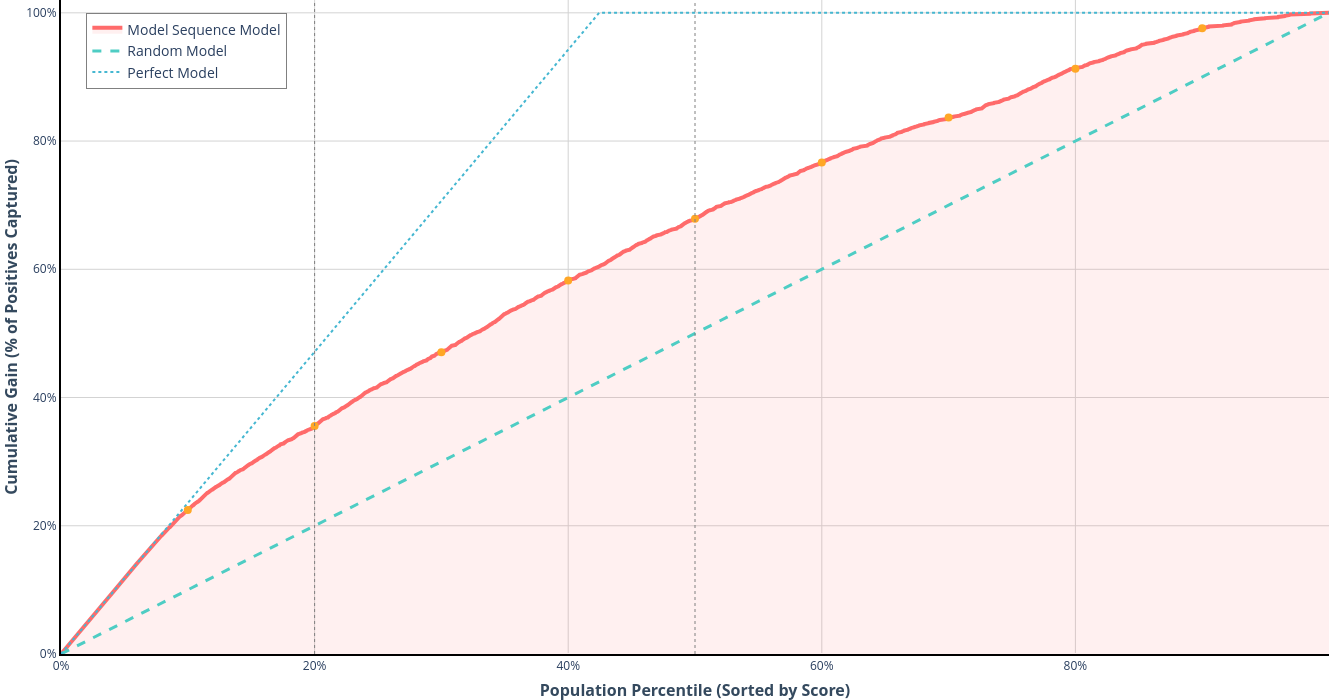

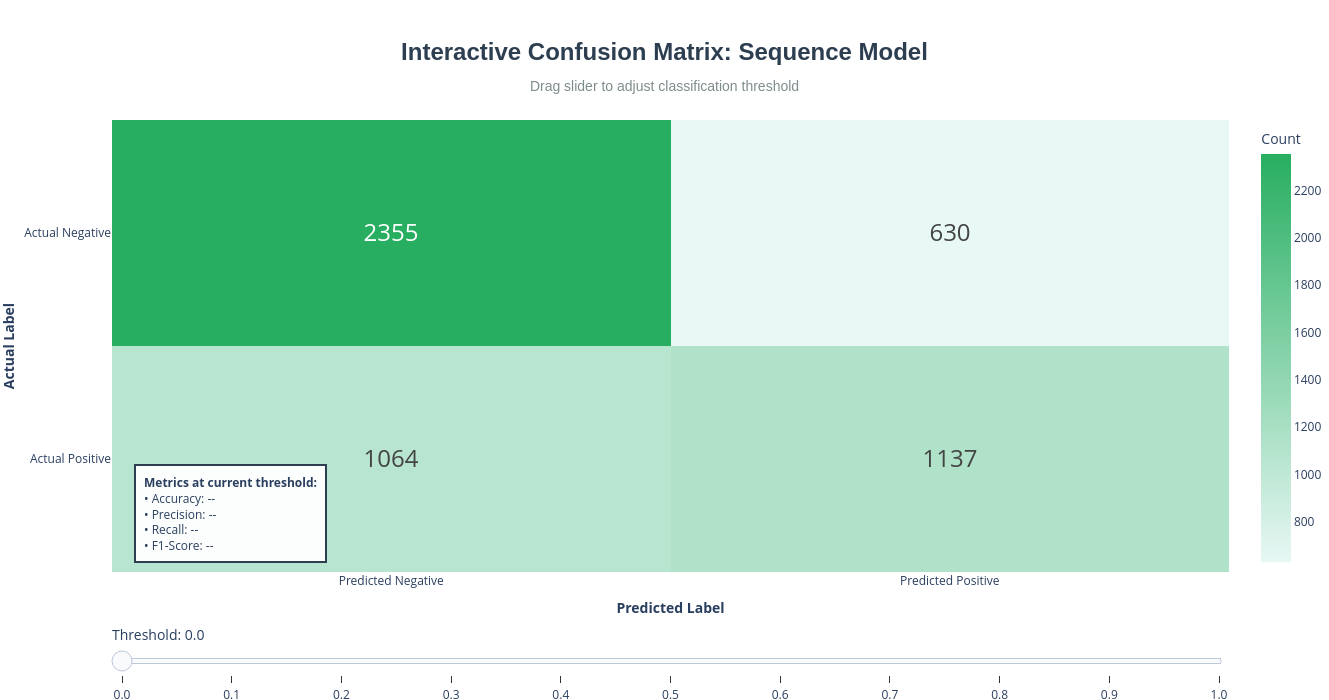

In [9]:
plots = log_all_plots(y_test_seq, y_pred_proba_seq, wandb_run_id, "Sequence Model")
for k, plot in plots.items():
    plot.show()

In [10]:
# Create comparison bar chart (only one extra chart)
print("\n📊 CREATING MODEL COMPARISON")
fig, ax = plt.subplots(figsize=(8, 6))
models = ['Customer', 'Sequence']

auc_customer = roc_auc_score(y_test, y_pred_proba)
auc_sequence = roc_auc_score(y_test_seq, y_pred_proba_seq)
aucs = [auc_customer, auc_sequence]

bars = ax.bar(models, aucs, color=['skyblue', 'lightcoral'])
ax.set_ylabel('AUC Score')
ax.set_title('Model AUC Comparison')
ax.set_ylim([0, 1])

# Add value labels on bars
for bar, auc in zip(bars, aucs):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{auc:.3f}', ha='center', va='bottom')


log_plot_as_image(fig, wandb_run_id, "model_comparison")
fig.show()
plt.close(fig)


print("\n" + "="*80)
print("RESULTS SUMMARY")
print("="*80)
print(f"Customer Model AUC: {auc_customer:.3f}")
print(f"Sequence Model AUC: {auc_sequence:.3f}")
print(f"Improvement: {auc_sequence - auc_customer:.3f}")


📊 CREATING MODEL COMPARISON



RESULTS SUMMARY
Customer Model AUC: 0.680
Sequence Model AUC: 0.730
Improvement: 0.050
